In [1]:
from pyspark.sql.functions import col, isnull, sum, when, isnan, count, max, corr, avg, round, date_trunc, unix_timestamp, from_unixtime, to_timestamp,weekofyear, stddev,concat, countDistinct, date_format,hour,lit,create_map

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Upload Dataset Using Pyspark

In [4]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the CSV file
df = spark.read.csv("./2019_Yellow_Taxi_Trip_Data.csv", header=True, inferSchema=True)

spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", "1000")

# Show the loaded data without truncating the column values
#df.show(n=20, truncate=False)


23/07/14 10:54:46 WARN Utils: Your hostname, Ifeoluwas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.179.58 instead (on interface en0)
23/07/14 10:54:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/14 10:54:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
row_count = df.count()
colunm_count = len(df.columns)
print('Number of rows: ', row_count)
print('Number of columns: ', colunm_count)

Number of rows:  84399019
Number of columns:  18


In [6]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|  246601|                   0|                    0|         246601|            0|    246601|            246601|           0|           0|      246601|          0|    0|      0|         0|           0|                    0

## Filtering for only Manhattan Area Codes

In [7]:
'4 12 13 24 41 42 43 45 48 50 68 74 75 79 87 88 90 100 103 104 105 107 113 114 116 120 125 127 128 137 140 141 142 143 144 148 151 152 153 158 161 162 163 164 166 170 186 194 202 209 211 224 229 230 231 232 233 234 236 237 238 239 243 244 246 249 261 262 263'.replace(" " , ",")

'4,12,13,24,41,42,43,45,48,50,68,74,75,79,87,88,90,100,103,104,105,107,113,114,116,120,125,127,128,137,140,141,142,143,144,148,151,152,153,158,161,162,163,164,166,170,186,194,202,209,211,224,229,230,231,232,233,234,236,237,238,239,243,244,246,249,261,262,263'

In [8]:
location = [4,12,13,24,41,42,43,45,48,50,68,74,75,79,87,88,90,100,103,104,105,107,113,114,116,120,125,127,128,137,140,141,142,143,144,148,151,152,153,158,161,162,163,164,166,170,186,194,202,209,211,224,229,230,231,232,233,234,236,237,238,239,243,244,246,249,261,262,263]

In [9]:
filtered_df = df.filter((col("PULocationID").isin(location)) & (col("DOLocationID").isin(location)))


In [10]:
print('Number of Rows: ' , filtered_df.count())

Number of Rows:  71056217


In [11]:
# Check the count of null values for each column
null_counts = filtered_df.select([sum(col(c).isNull().cast("integer")).alias(c) for c in filtered_df.columns])

# Check the count of NA values for each column
na_counts = filtered_df.select([sum(isnan(col(c)).cast("integer")).alias(c) for c in filtered_df.columns])

# Show the results
# null_counts.show()
# na_counts.show()

## Checking Data Types

In [12]:
filtered_df.dtypes

[('VendorID', 'int'),
 ('tpep_pickup_datetime', 'string'),
 ('tpep_dropoff_datetime', 'string'),
 ('passenger_count', 'int'),
 ('trip_distance', 'double'),
 ('RatecodeID', 'int'),
 ('store_and_fwd_flag', 'string'),
 ('PULocationID', 'int'),
 ('DOLocationID', 'int'),
 ('payment_type', 'int'),
 ('fare_amount', 'double'),
 ('extra', 'double'),
 ('mta_tax', 'double'),
 ('tip_amount', 'double'),
 ('tolls_amount', 'double'),
 ('improvement_surcharge', 'double'),
 ('total_amount', 'double'),
 ('congestion_surcharge', 'double')]

#### Changing tpep_pickup_datetime and  tpep_dropoff_datetime from string to unix_timestamp

In [13]:
filtered_df = filtered_df.withColumn('tpep_pickup_datetime', to_timestamp('tpep_pickup_datetime', 'MM/dd/yyyy hh:mm:ss a'))
filtered_df = filtered_df.withColumn('tpep_dropoff_datetime', to_timestamp('tpep_dropoff_datetime', 'MM/dd/yyyy hh:mm:ss a'))

In [14]:
filtered_df.dtypes

[('VendorID', 'int'),
 ('tpep_pickup_datetime', 'timestamp'),
 ('tpep_dropoff_datetime', 'timestamp'),
 ('passenger_count', 'int'),
 ('trip_distance', 'double'),
 ('RatecodeID', 'int'),
 ('store_and_fwd_flag', 'string'),
 ('PULocationID', 'int'),
 ('DOLocationID', 'int'),
 ('payment_type', 'int'),
 ('fare_amount', 'double'),
 ('extra', 'double'),
 ('mta_tax', 'double'),
 ('tip_amount', 'double'),
 ('tolls_amount', 'double'),
 ('improvement_surcharge', 'double'),
 ('total_amount', 'double'),
 ('congestion_surcharge', 'double')]

In [15]:
null_counts = filtered_df.select([sum(col(c).isNull().cast("integer")).alias(c) for c in filtered_df.columns])

# Show the results
# null_counts.show()

In [16]:
filtered_df = filtered_df.withColumn('tpep_pickup_unix', unix_timestamp('tpep_pickup_datetime'))
filtered_df = filtered_df.withColumn('tpep_dropoff_unix', unix_timestamp('tpep_dropoff_datetime'))

In [17]:
filtered_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----------------+-----------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|tpep_pickup_unix|tpep_dropoff_unix|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----------------+-----------------+
|       1| 2019-05-07 00:18:46|  2019-05-07 00:26:29|              2|          1.3|         1|                 N|     

## Checking for  Missings

In [18]:
null_counts = filtered_df.select([sum(col(c).isNull().cast("integer")).alias(c) for c in filtered_df.columns])

# Show the results
null_counts.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----------------+-----------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|tpep_pickup_unix|tpep_dropoff_unix|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----------------+-----------------+
|   40998|                   0|                    0|          40998|            0|     40998|             40998|     

## Features to be dropped 

In [19]:
# Specify the list of features to drop
features_to_drop = ['VendorID','RateCodeID', 'store_and_fwd_flag', 'payment_type',
                    'fare_amount', 'extra', 'mta_tax', 'improvement_surcharge',
                    'tip_amount', 'tolls_amount', 'total_amount','congestion_surcharge']

# Drop the features from the DataFrame
filtered_df = filtered_df.drop(*features_to_drop)


In [20]:
filtered_df.show()

+--------------------+---------------------+---------------+-------------+------------+------------+----------------+-----------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|tpep_pickup_unix|tpep_dropoff_unix|
+--------------------+---------------------+---------------+-------------+------------+------------+----------------+-----------------+
| 2019-05-07 00:18:46|  2019-05-07 00:26:29|              2|          1.3|         142|         162|      1557184726|       1557185189|
| 2019-05-07 00:32:34|  2019-05-07 00:36:34|              2|          0.5|         161|         230|      1557185554|       1557185794|
| 2019-05-07 00:47:53|  2019-05-07 00:56:45|              4|          2.0|         142|         230|      1557186473|       1557187005|
| 2019-05-07 00:52:30|  2019-05-07 00:56:18|              1|         1.03|         162|         164|      1557186750|       1557186978|
| 2019-05-07 00:56:17|  2019-05-07 01:00:29|    

In [21]:
filtered_df.count()

71056217

In [22]:
filtered_df.dtypes

[('tpep_pickup_datetime', 'timestamp'),
 ('tpep_dropoff_datetime', 'timestamp'),
 ('passenger_count', 'int'),
 ('trip_distance', 'double'),
 ('PULocationID', 'int'),
 ('DOLocationID', 'int'),
 ('tpep_pickup_unix', 'bigint'),
 ('tpep_dropoff_unix', 'bigint')]

In [23]:
null_counts = filtered_df.select([sum(col(c).isNull().cast("integer")).alias(c) for c in filtered_df.columns])

# Show the results
null_counts.show()

+--------------------+---------------------+---------------+-------------+------------+------------+----------------+-----------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|tpep_pickup_unix|tpep_dropoff_unix|
+--------------------+---------------------+---------------+-------------+------------+------------+----------------+-----------------+
|                   0|                    0|          40998|            0|           0|           0|               0|                0|
+--------------------+---------------------+---------------+-------------+------------+------------+----------------+-----------------+



Source: https://www.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page#:~:text=The%20maximum%20amount%20of%20passengers,of%20an%20adult%20passenger%20seated


The maximum amount of passengers allowed in a yellow taxicab by law is four (4) in a four (4) passenger taxicab or five (5) passengers in a five (5) passenger taxicab, except that an additional passenger must be accepted if such passenger is under the age of seven (7) and is held on the lap of an adult passenger seated in the rear.



In [24]:
filtered_df.select('passenger_count').distinct().show()

+---------------+
|passenger_count|
+---------------+
|              1|
|              6|
|              3|
|              5|
|              9|
|              4|
|              8|
|              2|
|              0|
|              7|
|           null|
+---------------+



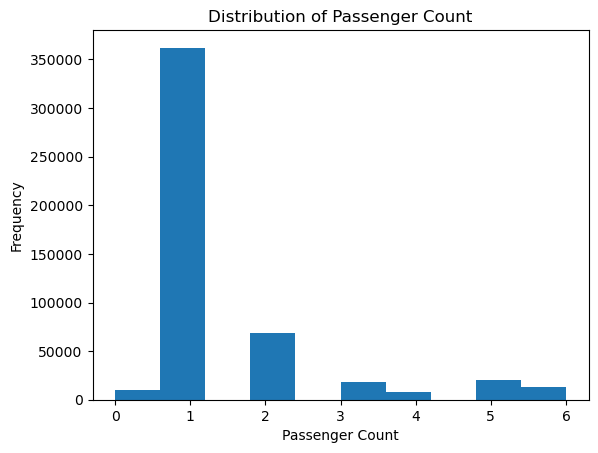

In [25]:
# Convert the passenger count column to Pandas DataFrame for plotting
passenger_count_df = filtered_df.select('passenger_count').limit(500000).toPandas()

# Plot a histogram of passenger count
plt.hist(passenger_count_df['passenger_count'], bins=10)
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.title('Distribution of Passenger Count')
plt.show()


In [26]:
filtered_df.filter(col('passenger_count')==0).count()

1286088

## Imputing Values 

In [27]:
filtered_df = filtered_df.filter(col('passenger_count') <= 5)


In [28]:
filtered_df.select('passenger_count').distinct().show()

+---------------+
|passenger_count|
+---------------+
|              1|
|              3|
|              5|
|              4|
|              2|
|              0|
+---------------+



In [29]:
avg_passenger_count = filtered_df.filter((col('passenger_count') != 0) & (col('passenger_count').isNotNull())).agg(avg('passenger_count')).first()[0]

In [30]:
filtered_df = filtered_df.fillna({'passenger_count': avg_passenger_count})

1.2. Time Series Imputation
While loading the dataset, we defined the index with the combination of Date and StartTime columns, if that is not clear, see the Data part above.☝️

One way to impute missing values in a time series data is to fill them with either the last or the next observed values. Pandas have fillna() function which has method parameter where we can choose “ffill” to fill with the next observed value or “bfill” to fill with the previously observed value.

source: https://towardsdatascience.com/imputing-missing-data-with-simple-and-advanced-techniques-f5c7b157fb87

In [31]:
filtered_df = filtered_df.withColumn('passenger_count', when(col('passenger_count') == 0, 1).otherwise(col('passenger_count')))

In [32]:
filtered_df.select('passenger_count').distinct().show()

+---------------+
|passenger_count|
+---------------+
|              1|
|              3|
|              5|
|              4|
|              2|
+---------------+



In [33]:
filtered_df.select('passenger_count').distinct().show()

+---------------+
|passenger_count|
+---------------+
|              1|
|              3|
|              5|
|              4|
|              2|
+---------------+



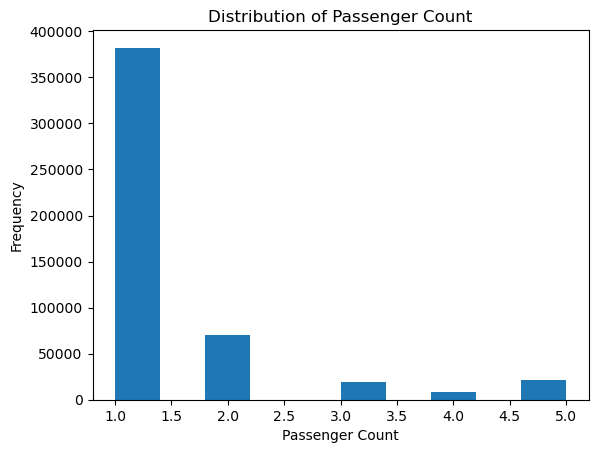

In [34]:
# Convert the passenger count column to Pandas DataFrame for plotting
passenger_count_df = filtered_df.select('passenger_count').limit(500000).toPandas()

# Plot a histogram of passenger count
plt.hist(passenger_count_df['passenger_count'], bins=10)
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.title('Distribution of Passenger Count')
plt.show()


In [35]:
filtered_df.show()

+--------------------+---------------------+---------------+-------------+------------+------------+----------------+-----------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|tpep_pickup_unix|tpep_dropoff_unix|
+--------------------+---------------------+---------------+-------------+------------+------------+----------------+-----------------+
| 2019-05-07 00:18:46|  2019-05-07 00:26:29|              2|          1.3|         142|         162|      1557184726|       1557185189|
| 2019-05-07 00:32:34|  2019-05-07 00:36:34|              2|          0.5|         161|         230|      1557185554|       1557185794|
| 2019-05-07 00:47:53|  2019-05-07 00:56:45|              4|          2.0|         142|         230|      1557186473|       1557187005|
| 2019-05-07 00:52:30|  2019-05-07 00:56:18|              1|         1.03|         162|         164|      1557186750|       1557186978|
| 2019-05-07 00:56:17|  2019-05-07 01:00:29|    

In [36]:
null_counts = filtered_df.select([sum(col(c).isNull().cast("integer")).alias(c) for c in filtered_df.columns])

# Show the results
null_counts.show()

+--------------------+---------------------+---------------+-------------+------------+------------+----------------+-----------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|tpep_pickup_unix|tpep_dropoff_unix|
+--------------------+---------------------+---------------+-------------+------------+------------+----------------+-----------------+
|                   0|                    0|              0|            0|           0|           0|               0|                0|
+--------------------+---------------------+---------------+-------------+------------+------------+----------------+-----------------+



# Dealing with Trip Distance

In [37]:
trip_dis = filtered_df.select('trip_distance').show()

+-------------+
|trip_distance|
+-------------+
|          1.3|
|          0.5|
|          2.0|
|         1.03|
|          1.3|
|         1.12|
|         4.49|
|         3.01|
|         6.25|
|         3.26|
|         2.63|
|         1.71|
|         2.63|
|         4.93|
|         2.84|
|          0.4|
|          0.5|
|         1.71|
|         3.63|
|         0.88|
+-------------+
only showing top 20 rows



In [38]:
max_distance = filtered_df.select(max('trip_distance')).first()[0]

In [39]:
print(max_distance)

19130.18


In [40]:
avg_dis = filtered_df.select(avg('trip_distance')).first()[0]
print(avg_dis)

1.8517843048202558


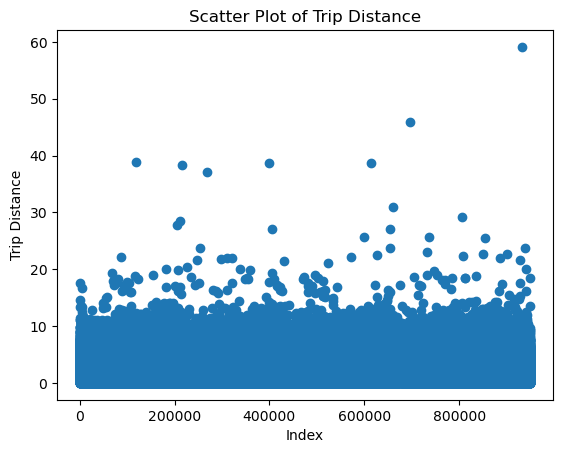

In [41]:
pandas_df = filtered_df.limit(950000).select("trip_distance").toPandas()

# Plot the scatter graph
plt.scatter(pandas_df.index, pandas_df["trip_distance"])
plt.xlabel("Index")
plt.ylabel("Trip Distance")
plt.title("Scatter Plot of Trip Distance")
plt.show()

Applying a 25% buffer

In [42]:
filtered_df = filtered_df.filter(filtered_df['trip_distance']<=65)

In [43]:
filtered_df.count()

69280247

In [44]:
filtered_df.select(max('trip_distance')).first()[0]

64.57

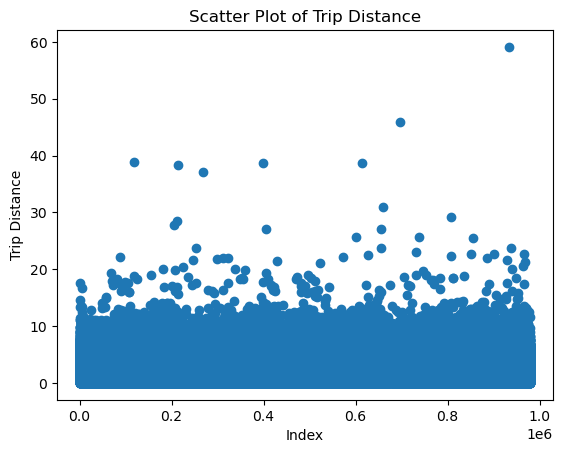

In [45]:
pandas_df = filtered_df.limit(980000).select("trip_distance").toPandas()

# Plot the scatter graph
plt.scatter(pandas_df.index, pandas_df["trip_distance"])
plt.xlabel("Index")
plt.ylabel("Trip Distance")
plt.title("Scatter Plot of Trip Distance")
plt.show()

In [46]:
from pyspark.sql.functions import max, min

# Check maximum and minimum Unix time values
max_unix_time = filtered_df.agg(max('tpep_pickup_unix')).collect()[0][0]
min_unix_time = filtered_df.agg(min('tpep_pickup_unix')).collect()[0][0]

print("Maximum Unix time:", max_unix_time)
print("Minimum Unix time:", min_unix_time)


Maximum Unix time: 3725742339
Minimum Unix time: 978307328


In [47]:
max2 = filtered_df.agg(max(filtered_df['tpep_dropoff_unix'])).collect()[0][0]
min2 = filtered_df.agg(min(filtered_df['tpep_dropoff_unix'])).collect()[0][0]

In [48]:
# print("Maximum Unix time:", max2)
# print("Minimum Unix time:", min2)

Filtering Dataset

In [49]:
min_unix = 1546300800
max_unix = 1577836800

In [50]:
filtered_df = filtered_df.filter((col('tpep_pickup_unix') >= min_unix) & (col('tpep_pickup_unix') <= max_unix) &
                                 (col('tpep_dropoff_unix') >= min_unix) & (col('tpep_dropoff_unix') <= max_unix))


In [51]:
filtered_df.count()

69278472

In [52]:
# # Save the filtered_df as a CSV file
# filtered_df.write.csv('./New_Taxi_Data.csv', header=True, mode='overwrite')

In [53]:
filtered_df.dtypes

[('tpep_pickup_datetime', 'timestamp'),
 ('tpep_dropoff_datetime', 'timestamp'),
 ('passenger_count', 'int'),
 ('trip_distance', 'double'),
 ('PULocationID', 'int'),
 ('DOLocationID', 'int'),
 ('tpep_pickup_unix', 'bigint'),
 ('tpep_dropoff_unix', 'bigint')]

Adding Pick up Day, Month, Hour
Drop off Day, Month, Hour


# Additional Pick-Up Time Features for ML Model

Pickup Day

In [54]:
filtered_df = filtered_df.withColumn('pickup_day', date_format('tpep_pickup_datetime', 'E'))

In [55]:
from pyspark.sql.functions import date_format, when

# Create a new column 'pickup_day_number' with numerical values for the days of the week
filtered_df = filtered_df.withColumn('pickup_day_number', when(date_format('tpep_pickup_datetime', 'E') == 'Mon', 1)
                                                    .when(date_format('tpep_pickup_datetime', 'E') == 'Tue', 2)
                                                    .when(date_format('tpep_pickup_datetime', 'E') == 'Wed', 3)
                                                    .when(date_format('tpep_pickup_datetime', 'E') == 'Thu', 4)
                                                    .when(date_format('tpep_pickup_datetime', 'E') == 'Fri', 5)
                                                    .when(date_format('tpep_pickup_datetime', 'E') == 'Sat', 6)
                                                    .when(date_format('tpep_pickup_datetime', 'E') == 'Sun', 7)
                                                    .otherwise(0))

# Drop the original 'pickup_day' column if no longer needed
filtered_df = filtered_df.drop('pickup_day')

Pickup hour

In [56]:
filtered_df = filtered_df.withColumn('pickup_hour', date_format('tpep_pickup_datetime', 'HH' ))

Pickup Month

In [57]:
filtered_df = filtered_df.withColumn('pickup_month', date_format('tpep_pickup_datetime', 'MM' ))

In [58]:
filtered_df.show()

+--------------------+---------------------+---------------+-------------+------------+------------+----------------+-----------------+-----------------+-----------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|tpep_pickup_unix|tpep_dropoff_unix|pickup_day_number|pickup_hour|pickup_month|
+--------------------+---------------------+---------------+-------------+------------+------------+----------------+-----------------+-----------------+-----------+------------+
| 2019-05-07 00:18:46|  2019-05-07 00:26:29|              2|          1.3|         142|         162|      1557184726|       1557185189|                2|         00|          05|
| 2019-05-07 00:32:34|  2019-05-07 00:36:34|              2|          0.5|         161|         230|      1557185554|       1557185794|                2|         00|          05|
| 2019-05-07 00:47:53|  2019-05-07 00:56:45|              4|          2.0|         142|         230|     

In [59]:
filtered_df = filtered_df.withColumn('pick_up_week_num', weekofyear('tpep_pickup_datetime'))


# Additional Drop-off Time Features for ML Model

In [60]:
filtered_df.dtypes

[('tpep_pickup_datetime', 'timestamp'),
 ('tpep_dropoff_datetime', 'timestamp'),
 ('passenger_count', 'int'),
 ('trip_distance', 'double'),
 ('PULocationID', 'int'),
 ('DOLocationID', 'int'),
 ('tpep_pickup_unix', 'bigint'),
 ('tpep_dropoff_unix', 'bigint'),
 ('pickup_day_number', 'int'),
 ('pickup_hour', 'string'),
 ('pickup_month', 'string'),
 ('pick_up_week_num', 'int')]

drop off day

In [61]:
filtered_df = filtered_df.withColumn('dropoff_day', date_format('tpep_dropoff_datetime', 'E'))

In [62]:
# Create a new column 'pickup_day_number' with numerical values for the days of the week
filtered_df = filtered_df.withColumn('dropoff_day_number', when(date_format('tpep_dropoff_datetime', 'E') == 'Mon', 1)
                                                    .when(date_format('tpep_dropoff_datetime', 'E') == 'Tue', 2)
                                                    .when(date_format('tpep_dropoff_datetime', 'E') == 'Wed', 3)
                                                    .when(date_format('tpep_dropoff_datetime', 'E') == 'Thu', 4)
                                                    .when(date_format('tpep_dropoff_datetime', 'E') == 'Fri', 5)
                                                    .when(date_format('tpep_dropoff_datetime', 'E') == 'Sat', 6)
                                                    .when(date_format('tpep_dropoff_datetime', 'E') == 'Sun', 7)
                                                    .otherwise(0))

# Drop the original 'pickup_day' column if no longer needed
filtered_df = filtered_df.drop('dropoff_day')

In [63]:
filtered_df = filtered_df.withColumn('dropoff_hour', date_format('tpep_dropoff_datetime', 'HH'))

In [64]:
filtered_df = filtered_df.withColumn('dropoff_month', date_format('tpep_dropoff_datetime', 'MM'))

In [65]:
filtered_df = filtered_df.withColumn('drop_off_week_num', weekofyear('tpep_dropoff_datetime'))


                    END

In [66]:
# # Save the filtered_df as a CSV file
# filtered_df.write.csv('./New_Taxi_Data.csv', header=True, mode='overwrite')

# Calculating Busyness Based on Z score

In [ ]:
from pyspark.sql.functions import date_format
from pyspark.sql import functions as F

# Group the data by 'PULocationID', 'pickup_hour', 'pickup_day_number', 'pickup_month' and calculate the sum of 'passenger_count' for pick-up
pickup_data = filtered_df.filter(F.col('PULocationID').isin(location)) \
    .groupBy('PULocationID', 'pickup_day_number', 'pickup_hour', 'pickup_month','pick_up_week_num').agg(
        F.sum('passenger_count').alias('sum_passenger_pickup')
    )

# Group the data by 'DOLocationID', 'dropoff_hour', 'dropoff_day_number', 'dropoff_month' and calculate the sum of 'passenger_count' for drop-off
dropoff_data = filtered_df.filter(F.col('DOLocationID').isin(location)) \
    .groupBy('DOLocationID', 'dropoff_day_number', 'dropoff_hour', 'dropoff_month', 'drop_off_week_num').agg(
        F.sum('passenger_count').alias('sum_passenger_dropoff')
    )

# Show the result for pick-up data
pickup_data.show()

# Show the result for drop-off data
dropoff_data.show()


In [ ]:
combined_data = pickup_data.join(
    dropoff_data, 
    (pickup_data.PULocationID == dropoff_data.DOLocationID) & 
    (pickup_data.pick_up_week_num == dropoff_data.drop_off_week_num), 
    'outer'  # change to 'inner' if you only want to keep rows with a match in both dataframes
)

In [ ]:

combined_data1 = combined_data.select("*", (col('sum_passenger_pickup') + col('sum_passenger_dropoff')).alias('Sum_Of_Passengers'))


In [ ]:
combined_data1 = combined_data.select("*", (col('sum_passenger_pickup') - col('sum_passenger_dropoff')).alias('Difference_of_Passengers'))


In [ ]:
combined_data1.dtypes

In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import mean, stddev, col

# Define the window
week_window = Window.partitionBy('pick_up_week_num')

# Calculate mean and standard deviation for each week
df = combined_data1.withColumn('mean_pickup', mean(col('sum_passenger_pickup')).over(week_window))
df = df.withColumn('stddev_pickup', stddev(col('sum_passenger_pickup')).over(week_window))

# Compute z-score for pickups
df = df.withColumn('zscore_pickup', (col('sum_passenger_pickup') - col('mean_pickup')) / col('stddev_pickup'))

# Repeat the process for dropoffs
week_window = Window.partitionBy('drop_off_week_num')

df = df.withColumn('mean_dropoff', mean(col('sum_passenger_dropoff')).over(week_window))
df = df.withColumn('stddev_dropoff', stddev(col('sum_passenger_dropoff')).over(week_window))

df = df.withColumn('zscore_dropoff', (col('sum_passenger_dropoff') - col('mean_dropoff')) / col('stddev_dropoff'))


In [ ]:
df = df.dropna()

In [ ]:
import scipy.stats as stats
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
cdf_udf = udf(lambda z: float(stats.norm.cdf(z)), DoubleType())

# Apply the UDF to z-score columns
df = df.withColumn("zscore_pickup_percentile", cdf_udf("zscore_pickup"))
df = df.withColumn("zscore_dropoff_percentile", cdf_udf("zscore_dropoff"))

In [ ]:
df_busy = df.select('PULocationID', 'pickup_hour',  'DOLocationID', 'dropoff_hour','zscore_pickup_percentile', 'zscore_dropoff_percentile', 'pick_up_week_num', 'drop_off_week_num')




In [ ]:
df_busy = df_busy.withColumn('zscore_pickup_percentile', col('zscore_pickup_percentile') * 100)\
                 .withColumn('zscore_dropoff_percentile', col('zscore_dropoff_percentile') * 100)


In [ ]:
from pyspark.sql.functions import col

df_busy = df_busy.withColumn('zscore_pickup_percentile', col('zscore_pickup_percentile').cast('int')) \
                 .withColumn('zscore_dropoff_percentile', col('zscore_dropoff_percentile').cast('int')) \
                 .withColumn('pickup_hour', col('pickup_hour').cast('int')) \
                 .withColumn('dropoff_hour', col('dropoff_hour').cast('int'))

In [ ]:
df_busy.dtype()

In [ ]:
df_busy.to_csv("./z_score_model", header= True)

In [ ]:
df_busy.write.csv('./Z_Score_Busyness.csv', header=True, mode='overwrite')

# Data Analytics

In [ ]:
# Convert to pandas dataframe
pdf = filtered_df.limit(950000).toPandas()

# Convert the datetime columns to datetime type
pdf['tpep_pickup_datetime'] = pd.to_datetime(pdf['tpep_pickup_datetime'])
pdf['tpep_dropoff_datetime'] = pd.to_datetime(pdf['tpep_dropoff_datetime'])

# Create new columns for hour
pdf['pickup_hour'] = pdf['tpep_pickup_datetime'].dt.hour
pdf['dropoff_hour'] = pdf['tpep_dropoff_datetime'].dt.hour

# Plot
plt.figure(figsize=(12,6))
sns.distplot(pdf['pickup_hour'], bins=24, kde=False, color='blue', label='Pickup')
sns.distplot(pdf['dropoff_hour'], bins=24, kde=False, color='red', label='Dropoff')
plt.title('Distribution of Pickup and Dropoff Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='passenger_count', data=pdf)
plt.title('Distribution of Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,12))

sns.countplot(x='PULocationID', data=pdf, ax=ax[0])
ax[0].set_title('Distribution of Pickup Locations')
ax[0].set_xlabel('Pickup Location ID')
ax[0].set_ylabel('Frequency')

sns.countplot(x='DOLocationID', data=pdf, ax=ax[1])
ax[1].set_title('Distribution of Dropoff Locations')
ax[1].set_xlabel('Dropoff Location ID')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12,18))

sns.countplot(x='pickup_day', data=pdf, ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Pickup Days')
ax[0, 0].set_xlabel('Day of the Week')
ax[0, 0].set_ylabel('Frequency')

sns.countplot(x='pickup_hour', data=pdf, ax=ax[0, 1])
ax[0, 1].set_title('Distribution of Pickup Hours')
ax[0, 1].set_xlabel('Hour of the Day')
ax[0, 1].set_ylabel('Frequency')

sns.countplot(x='dropoff_day', data=pdf, ax=ax[1, 1])
ax[1, 1].set_title('Distribution of Dropoff Days')
ax[1, 1].set_xlabel('Day of the Week')
ax[1, 1].set_ylabel('Frequency')

sns.countplot(x='dropoff_hour', data=pdf, ax=ax[2, 0])
ax[2, 0].set_title('Distribution of Dropoff Hours')
ax[2, 0].set_xlabel('Hour of the Day')
ax[2, 0].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to pandas dataframe
pdf = filtered_df.limit(950000).toPandas()

# Calculate correlation matrix
corr = pdf.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()


In [ ]:
avg_distance_per_hour = pdf.groupby('pickup_hour')['trip_distance'].mean()

plt.figure(figsize=(12,6))
sns.barplot(x=avg_distance_per_hour.index, y=avg_distance_per_hour.values, color='b')
plt.title('Average Trip Distance per Pickup Hour')
plt.xlabel('Pickup Hour')
plt.ylabel('Average Trip Distance')
plt.show()



In [ ]:
avg_passengers_per_hour = pdf.groupby('pickup_hour')['passenger_count'].mean()

plt.figure(figsize=(12,6))
sns.barplot(x=avg_passengers_per_hour.index, y=avg_passengers_per_hour.values, color='b')
plt.title('Average Passenger Count per Pickup Hour')
plt.xlabel('Pickup Hour')
plt.ylabel('Average Passenger Count')
plt.show()


In [ ]:
avg_passengers_per_dropoff_hour = pdf.groupby('dropoff_hour')['passenger_count'].mean()

plt.figure(figsize=(12,6))
sns.barplot(x=avg_passengers_per_dropoff_hour.index, y=avg_passengers_per_dropoff_hour.values, color='b')
plt.title('Average Passenger Count per Dropoff Hour')
plt.xlabel('Dropoff Hour')
plt.ylabel('Average Passenger Count')
plt.show()


In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(pdf['passenger_count'], bins=50, kde=True)
plt.title('Histogram of Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.show()


In [ ]:
count_per_passenger_count = pdf['passenger_count'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=count_per_passenger_count.index, y=count_per_passenger_count.values, color='b')
plt.title('Count per Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Count')
plt.show()


In [ ]:
count_per_dropoff_day = pdf['dropoff_day_number'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=count_per_dropoff_day.index, y=count_per_dropoff_day.values, color='b')
plt.title('Count per Dropoff Day')
plt.xlabel('Dropoff Day (1=Monday, 7=Sunday)')
plt.ylabel('Count')
plt.show()


In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(pdf['dropoff_month'], bins=12, kde=False)
plt.title('Histogram of Dropoff Month')
plt.xlabel('Dropoff Month')
plt.ylabel('Frequency')
plt.xticks(range(1, 13))  # This will set the x-axis ticks to be the months (1-12)
plt.show()


In [ ]:
# Calculate the number of drop offs per hour
dropoffs_per_hour = pdf['dropoff_hour'].value_counts().sort_index()

# Calculate the average number of drop offs per hour
avg_dropoffs_per_hour = dropoffs_per_hour.mean()

# Create a bar plot
plt.figure(figsize=(12,6))
sns.barplot(x=dropoffs_per_hour.index, y=dropoffs_per_hour.values, color='b')
plt.axhline(avg_dropoffs_per_hour, color='r', linestyle='--')  # This adds a horizontal line for the average
plt.title('Number of Drop Offs per Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Drop Offs')
plt.show()


In [ ]:
# Calculate the number of pickups per hour
pickups_per_hour = pdf['pickup_hour'].value_counts().sort_index()

# Calculate the average number of pickups per hour
avg_pickups_per_hour = pickups_per_hour.mean()

# Create a bar plot
plt.figure(figsize=(12,6))
sns.barplot(x=pickups_per_hour.index, y=pickups_per_hour.values, color='b')
plt.axhline(avg_pickups_per_hour, color='r', linestyle='--')  # This adds a horizontal line for the average
plt.title('Number of Pickups per Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Pickups')
plt.show()


In [ ]:
from pyspark.sql import functions as F

# Group by dropoff_hour and count the number of rows for each group
dropoff_counts = filtered_df.groupBy("dropoff_hour").count()

# Sort the result in descending order of count
busiest_hours = dropoff_counts.sort(F.desc("count"))

# Show the result
busiest_hours.show()


In [ ]:
import pickle

In [ ]:
pickled_model = pickle.load(open('randomforest.pkl','rb'))

In [ ]:
dummy_data = {'DOLocationID': 4,
 'dropoff_hour': 0,
 'dropoff_month': 1,
 'dropoff_day_number': 1}

# Convert the dictionary to a DataFrame
test_data_df = pd.DataFrame([dummy_data])

pickled_model.predict(test_data_df)

In [ ]:
import joblib
model = joblib.load('randomforest.pkl')
model.predict(test_data_df)